# AWS Glue Studio Notebook
##### This code analysis data of Youtube channels and produce insight on the data


##### Import the modules required for the program

##### Import the modules required for the program

In [4]:
%glue_version 4.0
%worker_type G.1X
%number_of_workers 5

import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
import matplotlib.pyplot as plt
import numpy as np
  
sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

You are already connected to a glueetl session 75d2cc11-6b1a-4dd4-a0bf-539b113ecab5.

No change will be made to the current session that is set as glueetl. The session configuration change will apply to newly created sessions.


Setting Glue version to: 4.0


You are already connected to a glueetl session 75d2cc11-6b1a-4dd4-a0bf-539b113ecab5.

No change will be made to the current session that is set as glueetl. The session configuration change will apply to newly created sessions.


Previous worker type: G.1X
Setting new worker type to: G.1X


You are already connected to a glueetl session 75d2cc11-6b1a-4dd4-a0bf-539b113ecab5.

No change will be made to the current session that is set as glueetl. The session configuration change will apply to newly created sessions.


Previous number of workers: 5
Setting new number of workers to: 5



##### Analysis of number of subscribers for each Youtube Channel 

In [5]:
channel_data_subscriber = spark.sql("select channel_name,subscriber from (select channel_name,subscriber, inserted_date,\
dense_rank( ) over(partition by channel_name order by inserted_date desc) as rank  from enriched.channel_data) temp where temp.rank =1 ")
channel_data_subscriber.show(10,False)

+-----------------------+----------+
|channel_name           |subscriber|
+-----------------------+----------+
|Berita Harian Singapura|5040      |
|Tamil Murasu           |4970      |
|The Business Times     |29200     |
|The Straits Times      |596000    |
|zaobaosg               |196000    |
+-----------------------+----------+


##### Plotting Pie chart for number of subscribers for each Youtube Channel 

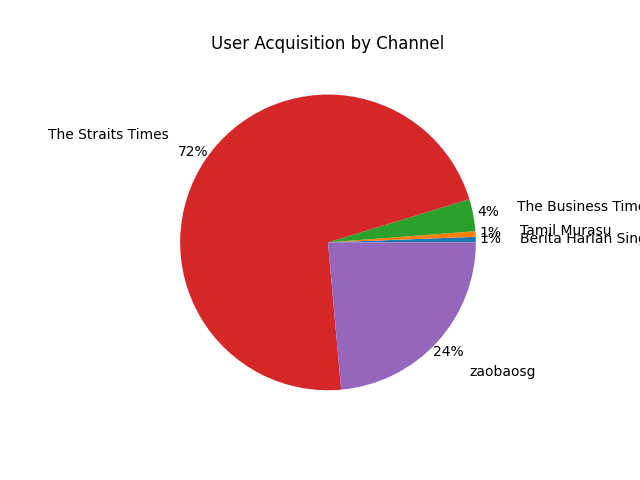

In [12]:
plt.clf()
sub_data = channel_data_subscriber.select('subscriber').rdd.flatMap(lambda x: x).collect()
channel_name_sub = channel_data_subscriber.select('channel_name').rdd.flatMap(lambda x: x).collect()
y = np.array(sub_data)
mylabels = channel_name_sub
plt.title('User Acquisition by Channel')
plt.pie(y, labels = mylabels ,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show() 
%matplot plt

#### Analysis of number of Videos published by each Youtube Channel 

In [13]:
channel_data_video_count = spark.sql("select c.channel_name, v.playlist_id,count(video_id) as video_count  from (select * from enriched.video_details \
where inserted_date = (select distinct max(inserted_date) from enriched.video_details)) v left join \
(select * from enriched.channel_data where inserted_date = (select distinct max(inserted_date) from enriched.channel_data)) c on v.inserted_Date = \
c.inserted_date and c.playlist_id =\
v.playlist_id group by c.channel_name,v.playlist_id  ")
channel_data_video_count.show(10,False)

+-----------------------+------------------------+-----------+
|channel_name           |playlist_id             |video_count|
+-----------------------+------------------------+-----------+
|Tamil Murasu           |UUs0xZ60FSNxFxHPVFFsXNTA|535        |
|zaobaosg               |UUrbQxu0YkoVWu2dw5b1MzNg|5358       |
|The Straits Times      |UU4p_I9eiRewn2KoU-nawrDg|20000      |
|Berita Harian Singapura|UU_WgSFSkn7112rmJQcHSUIQ|463        |
|The Business Times     |UU0GP1HDhGZTLih7B89z_cTg|1414       |
+-----------------------+------------------------+-----------+


#### Plotting Pie chart for number of videos published for each Youtube Channel

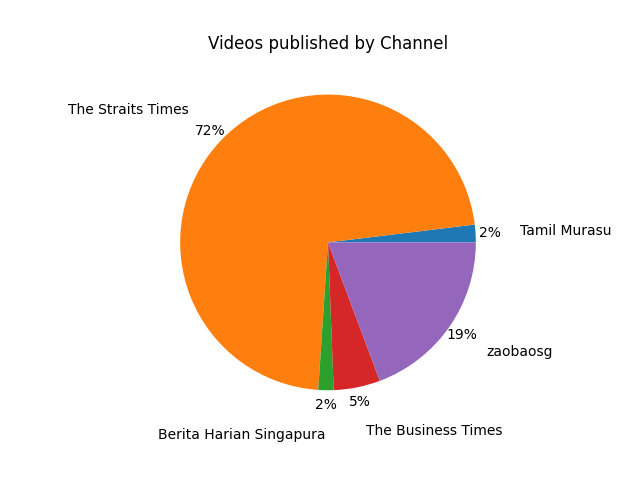

In [16]:
plt.clf()
video_count_view = channel_data_video_count.select('video_count').rdd.flatMap(lambda x: x).collect()
channel_name_view = channel_data_video_count.select('channel_name').rdd.flatMap(lambda x: x).collect()
y = np.array(video_count_view)
mylabels = channel_name_view
plt.title('Videos published by Channel')
plt.pie(y, labels = mylabels ,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show() 
%matplot plt

#### Analysis of trend for video published by each channel over past 12 months

In [17]:
channel_video_trnd = spark.sql("select t.channel_name,t.video_counts,t.published_month, \
date_format(from_unixtime(unix_timestamp(t.published_month||'01' ,'yyyyMMdd'), 'yyyy-MM-dd'),'MMM yyyy')  as publishedmonthyear \
from (select c.channel_name,int(date_format(v.published_date, 'yyyyMM')) as published_month ,count(1) as video_counts from enriched.video_details v left join \
enriched.channel_data c on v.playlist_id = c.playlist_id and v.inserted_date = c.inserted_date where \
v.published_date between current_date -INTERVAL '11' month and current_date \
group by c.channel_name,int(date_format(v.published_date, 'yyyyMM')) order by c.channel_name asc ,int(date_format(v.published_date, 'yyyyMM')) asc) t  ")
channel_video_trnd.show(10000, False)

+-----------------------+------------+---------------+------------------+
|channel_name           |video_counts|published_month|publishedmonthyear|
+-----------------------+------------+---------------+------------------+
|Berita Harian Singapura|70          |202310         |Oct 2023          |
|Berita Harian Singapura|210         |202311         |Nov 2023          |
|Berita Harian Singapura|140         |202312         |Dec 2023          |
|Berita Harian Singapura|196         |202401         |Jan 2024          |
|Berita Harian Singapura|112         |202402         |Feb 2024          |
|Berita Harian Singapura|203         |202403         |Mar 2024          |
|Berita Harian Singapura|203         |202404         |Apr 2024          |
|Berita Harian Singapura|196         |202405         |May 2024          |
|Berita Harian Singapura|98          |202406         |Jun 2024          |
|Berita Harian Singapura|105         |202407         |Jul 2024          |
|Berita Harian Singapura|119         |

#### Plotting Line chart for number of video publsihed each Youtube Channel for last 12 months

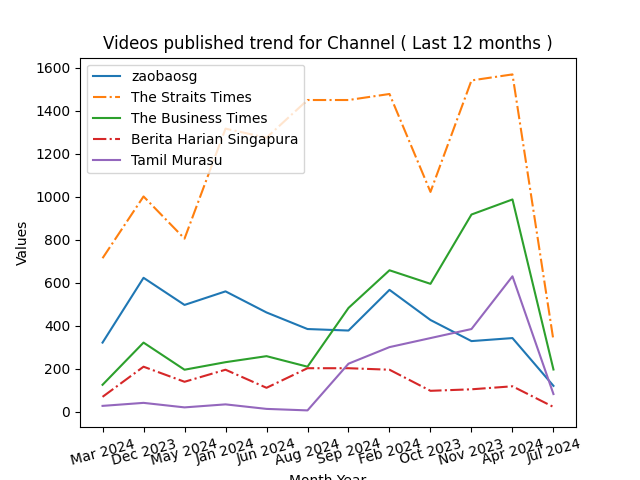

In [19]:
plt.clf()
x = channel_video_trnd.select('publishedmonthyear').distinct().rdd.flatMap(lambda x: x).collect()
y1 = channel_video_trnd.where('channel_name = "zaobaosg"').select('video_counts').rdd.flatMap(lambda x: x).collect()
y2 = channel_video_trnd.where('channel_name = "The Straits Times"').select('video_counts').rdd.flatMap(lambda x: x).collect()
y3 = channel_video_trnd.where('channel_name = "The Business Times"').select('video_counts').rdd.flatMap(lambda x: x).collect()
y4 = channel_video_trnd.where('channel_name = "Berita Harian Singapura"').select('video_counts').rdd.flatMap(lambda x: x).collect()
y5 = channel_video_trnd.where('channel_name = "Tamil Murasu"').select('video_counts').rdd.flatMap(lambda x: x).collect()

plt.plot(x, y1,label="zaobaosg")
plt.plot(x, y2,'-.',label="The Straits Times")
plt.plot(x, y3,label="The Business Times")
plt.plot(x, y4,'-.',label="Berita Harian Singapura")
plt.plot(x, y5,label="Tamil Murasu")

plt.xlabel("Month Year")
plt.ylabel("Values")
plt.title('Videos published trend for Channel ( Last 12 months )')
plt.legend()
plt.xticks(rotation=15)
plt.show()
%matplot plt

#### Analysis on most watched videos for each Youtube Channel

In [20]:
most_video_details_channel = spark.sql("select c.channel_name,temp.views, temp.video_id from (select v.*,c.playlist_id,dense_rank() over(partition by c.playlist_id \
order by v.views desc) as rank from (select * from enriched.video_details_dly where \
inserted_date =(select max(inserted_date) from enriched.video_details_dly ) ) v left join (select * from enriched.video_details where \
inserted_date =(select max(inserted_date) from enriched.video_details )) c on \
c.video_id = v.video_id and c.inserted_date = v.inserted_date) temp  left join \
(select * from enriched.channel_data where inserted_date =(select max(inserted_date ) from enriched.channel_data \
)) c on temp.playlist_id = c.playlist_id where temp.rank =1  ")
most_video_details_channel.show(10,False)

+-----------------------+--------+-----------+
|channel_name           |views   |video_id   |
+-----------------------+--------+-----------+
|The Business Times     |1888146 |q4Lftwq98DY|
|The Straits Times      |15316546|uEjwLKE0cCQ|
|Berita Harian Singapura|311788  |Hjm6jm546s8|
|zaobaosg               |1223877 |g_rn5Behgek|
|Tamil Murasu           |442813  |LnO3GWf58-4|
+-----------------------+--------+-----------+


#### Further own analysis


#### 1) Analysis of likes received for each Youtube Channel for past 12 months 

In [23]:
channel_data_mnthly_Top10 = spark.sql("select channel_name,(totalviews/1000) as totalviews,published_month,\
date_format(from_unixtime(unix_timestamp(published_month||'01' ,'yyyyMMdd'), 'yyyy-MM-dd'),'MMM yyyy')  as publishedmonthyear\
 from enriched.channel_data_mnthly where  published_month between \
date_format(current_date -INTERVAL '11' month,'yyyyMM') and date_format(current_date, 'yyyyMM')  order by published_month asc  \
")


#### Views Analysis of The Straits Times channel

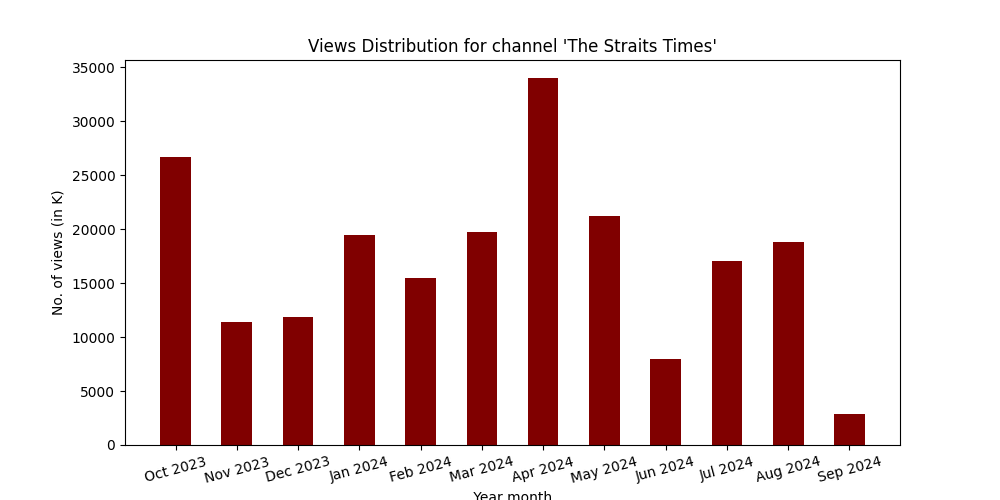

In [25]:
plt.clf()
x = channel_data_mnthly_Top10.where("channel_name = 'The Straits Times'").select('publishedmonthyear').rdd.flatMap(lambda x: x).collect()
y= channel_data_mnthly_Top10.where("channel_name = 'The Straits Times'").select('totalviews').rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(x, y, color ='maroon', 
        width = 0.5)

plt.xlabel(" Year month ")
plt.ylabel("No. of views (in K)")
plt.title("Views Distribution for channel 'The Straits Times'")
plt.xticks(rotation=15)
plt.show()
%matplot plt

#### Views Analysis of Tamil Murasu channel

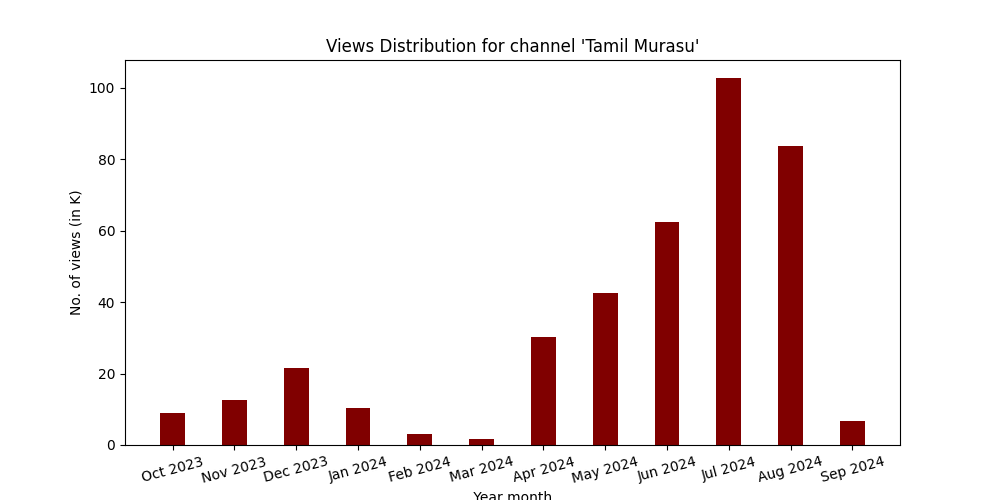

In [26]:

#plot
plt.clf()
x = channel_data_mnthly_Top10.where("channel_name = 'Tamil Murasu'").select('publishedmonthyear').rdd.flatMap(lambda x: x).collect()
y= channel_data_mnthly_Top10.where("channel_name = 'Tamil Murasu'").select('totalviews').rdd.flatMap(lambda x: x).collect()
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(x, y, color ='maroon', 
        width = 0.4)

plt.xlabel(" Year month ")
plt.ylabel("No. of views (in K)")
plt.title("Views Distribution for channel 'Tamil Murasu'")
plt.xticks(rotation=15)
plt.show()
%matplot plt

#### Views Analysis of The Business Times channel

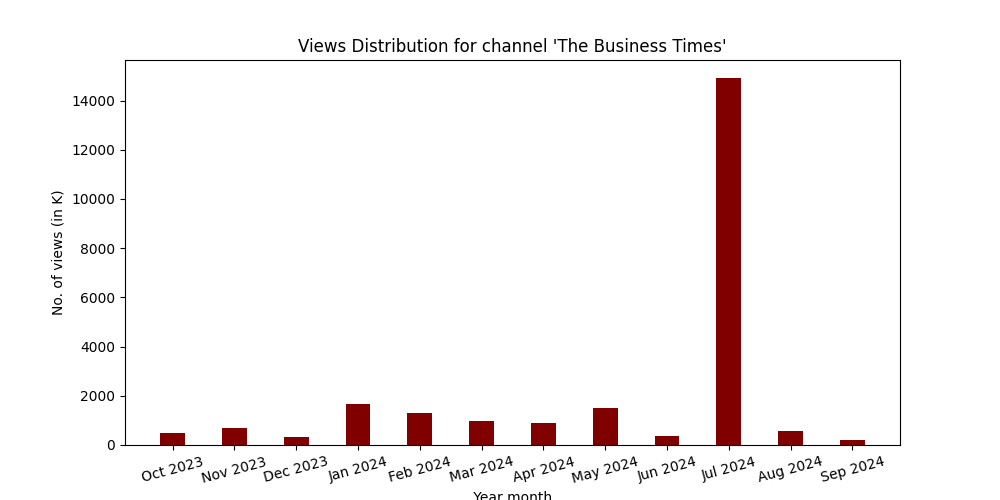

In [27]:
#plot
plt.clf()
x = channel_data_mnthly_Top10.where("channel_name = 'The Business Times'").select('publishedmonthyear').rdd.flatMap(lambda x: x).collect()
y= channel_data_mnthly_Top10.where("channel_name = 'The Business Times'").select('totalviews').rdd.flatMap(lambda x: x).collect()
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(x, y, color ='maroon', 
        width = 0.4)

plt.xlabel(" Year month ")
plt.ylabel("No. of views (in K)")
plt.title("Views Distribution for channel 'The Business Times'")
plt.xticks(rotation=15)
plt.show()
%matplot plt


#### Views Analysis of Berita Harian Singapura channel

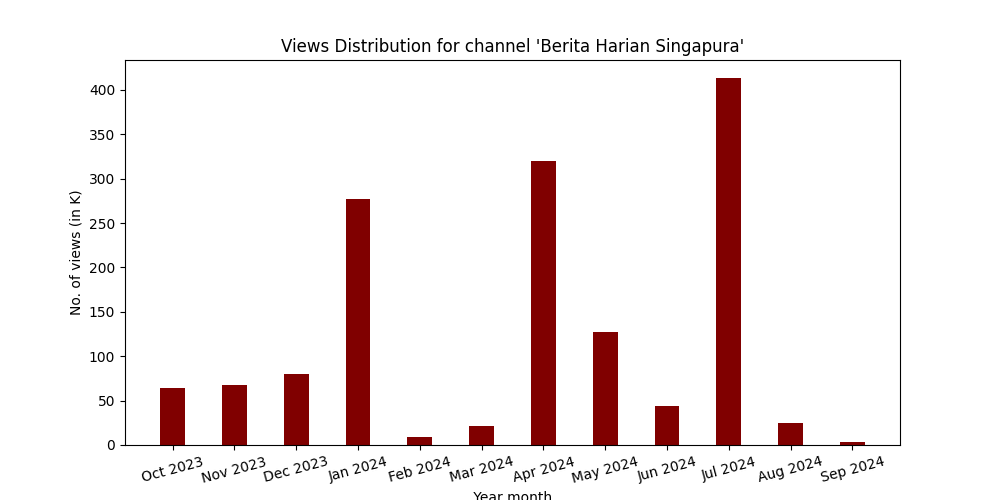

In [28]:

#plot
plt.clf()
x = channel_data_mnthly_Top10.where("channel_name = 'Berita Harian Singapura'").select('publishedmonthyear').rdd.flatMap(lambda x: x).collect()
y= channel_data_mnthly_Top10.where("channel_name = 'Berita Harian Singapura'").select('totalviews').rdd.flatMap(lambda x: x).collect()
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(x, y, color ='maroon', 
        width = 0.4)

plt.xlabel(" Year month ")
plt.ylabel("No. of views (in K)")
plt.title("Views Distribution for channel 'Berita Harian Singapura'")
plt.xticks(rotation=15)
plt.show()
%matplot plt

#### Views Analysis of zaobaosg channel

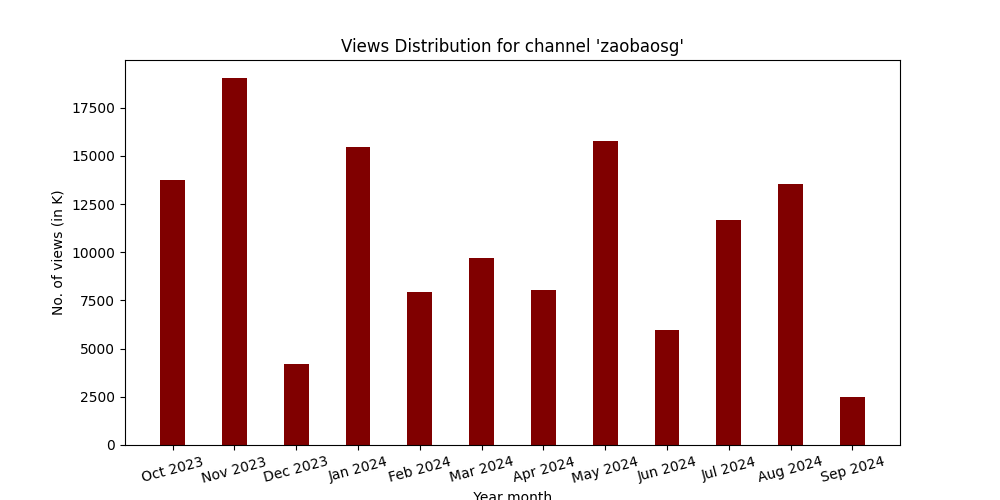

In [29]:

#plot
plt.clf()
x = channel_data_mnthly_Top10.where("channel_name = 'zaobaosg'").select('publishedmonthyear').rdd.flatMap(lambda x: x).collect()
y= channel_data_mnthly_Top10.where("channel_name = 'zaobaosg'").select('totalviews').rdd.flatMap(lambda x: x).collect()
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(x, y, color ='maroon', 
        width = 0.4)

plt.xlabel(" Year month ")
plt.ylabel("No. of views (in K)")
plt.title("Views Distribution for channel 'zaobaosg'")
plt.xticks(rotation=15)
plt.show()
%matplot plt
